Most of the dependencies are handled in the other modules, but we import a few general ones here for use below and future expansion purposes.
Notice that we are also modifying the matplotlib settings to work with LaTeX math-mode syntax.

In [1]:
from matplotlib import pyplot as plt
from jupyter_plotter import plot_jupyter_figure
import pymatching # Decoding
from circuit_generators import *
from sampling_functions import *
import numpy as np
from copy import deepcopy

# Also define the number of worker nodes here
n_worker_nodes = 8

# Surface code specifications
d = 4
r = 2
p = 0.01
use_rotated_z = True

# Bit types
binary_t = np.int8 # Could use even less if numpy allowed
packed_t = np.int8 # Packed bit type
if d<=8:
  pass
elif d>8 and d<=16:
  packed_t = np.int16
elif d>16 and d<=32:
  packed_t = np.int32
elif d>32 and d<=64:
  packed_t = np.int64
elif d>64 and d<=128:
  packed_t = np.int128
elif d>128 and d<=256:
  packed_t = np.int256
else:
  raise RuntimeError("d is too large.")
time_t = np.int8

# Measurement index type
idx_t = np.int8
n_all_measurements = r*(d**2-1) + d**2
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int16
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int32
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int64
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int128
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int256
if n_all_measurements > np.iinfo(idx_t).max:
  raise RuntimeError("idx_t is too small.")

Average flip rate: 0.1918155
QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(6, 0) 6
QUBIT_COORDS(7, 1) 7
QUBIT_COORDS(1, 3) 10
QUBIT_COORDS(2, 2) 11
QUBIT_COORDS(3, 3) 12
QUBIT_COORDS(4, 2) 13
QUBIT_COORDS(5, 3) 14
QUBIT_COORDS(6, 2) 15
QUBIT_COORDS(7, 3) 16
QUBIT_COORDS(0, 4) 18
QUBIT_COORDS(1, 5) 19
QUBIT_COORDS(2, 4) 20
QUBIT_COORDS(3, 5) 21
QUBIT_COORDS(4, 4) 22
QUBIT_COORDS(5, 5) 23
QUBIT_COORDS(6, 4) 24
QUBIT_COORDS(7, 5) 25
QUBIT_COORDS(8, 4) 26
QUBIT_COORDS(1, 7) 28
QUBIT_COORDS(2, 6) 29
QUBIT_COORDS(3, 7) 30
QUBIT_COORDS(4, 6) 31
QUBIT_COORDS(5, 7) 32
QUBIT_COORDS(6, 6) 33
QUBIT_COORDS(7, 7) 34
QUBIT_COORDS(2, 8) 38
QUBIT_COORDS(6, 8) 42
R 1 3 5 7 10 12 14 16 19 21 23 25 28 30 32 34
X_ERROR(0.01) 1 3 5 7 10 12 14 16 19 21 23 25 28 30 32 34
R 2 6 11 13 15 18 20 22 24 26 29 31 33 38 42
X_ERROR(0.01) 2 6 11 13 15 18 20 22 24 26 29 31 33 38 42
TICK
DEPOLARIZE1(0.01) 1 3 5 7 10 12 14 16 19 21 23 25 28 30 32 34
H 2 6 13 20 24 31 38 4

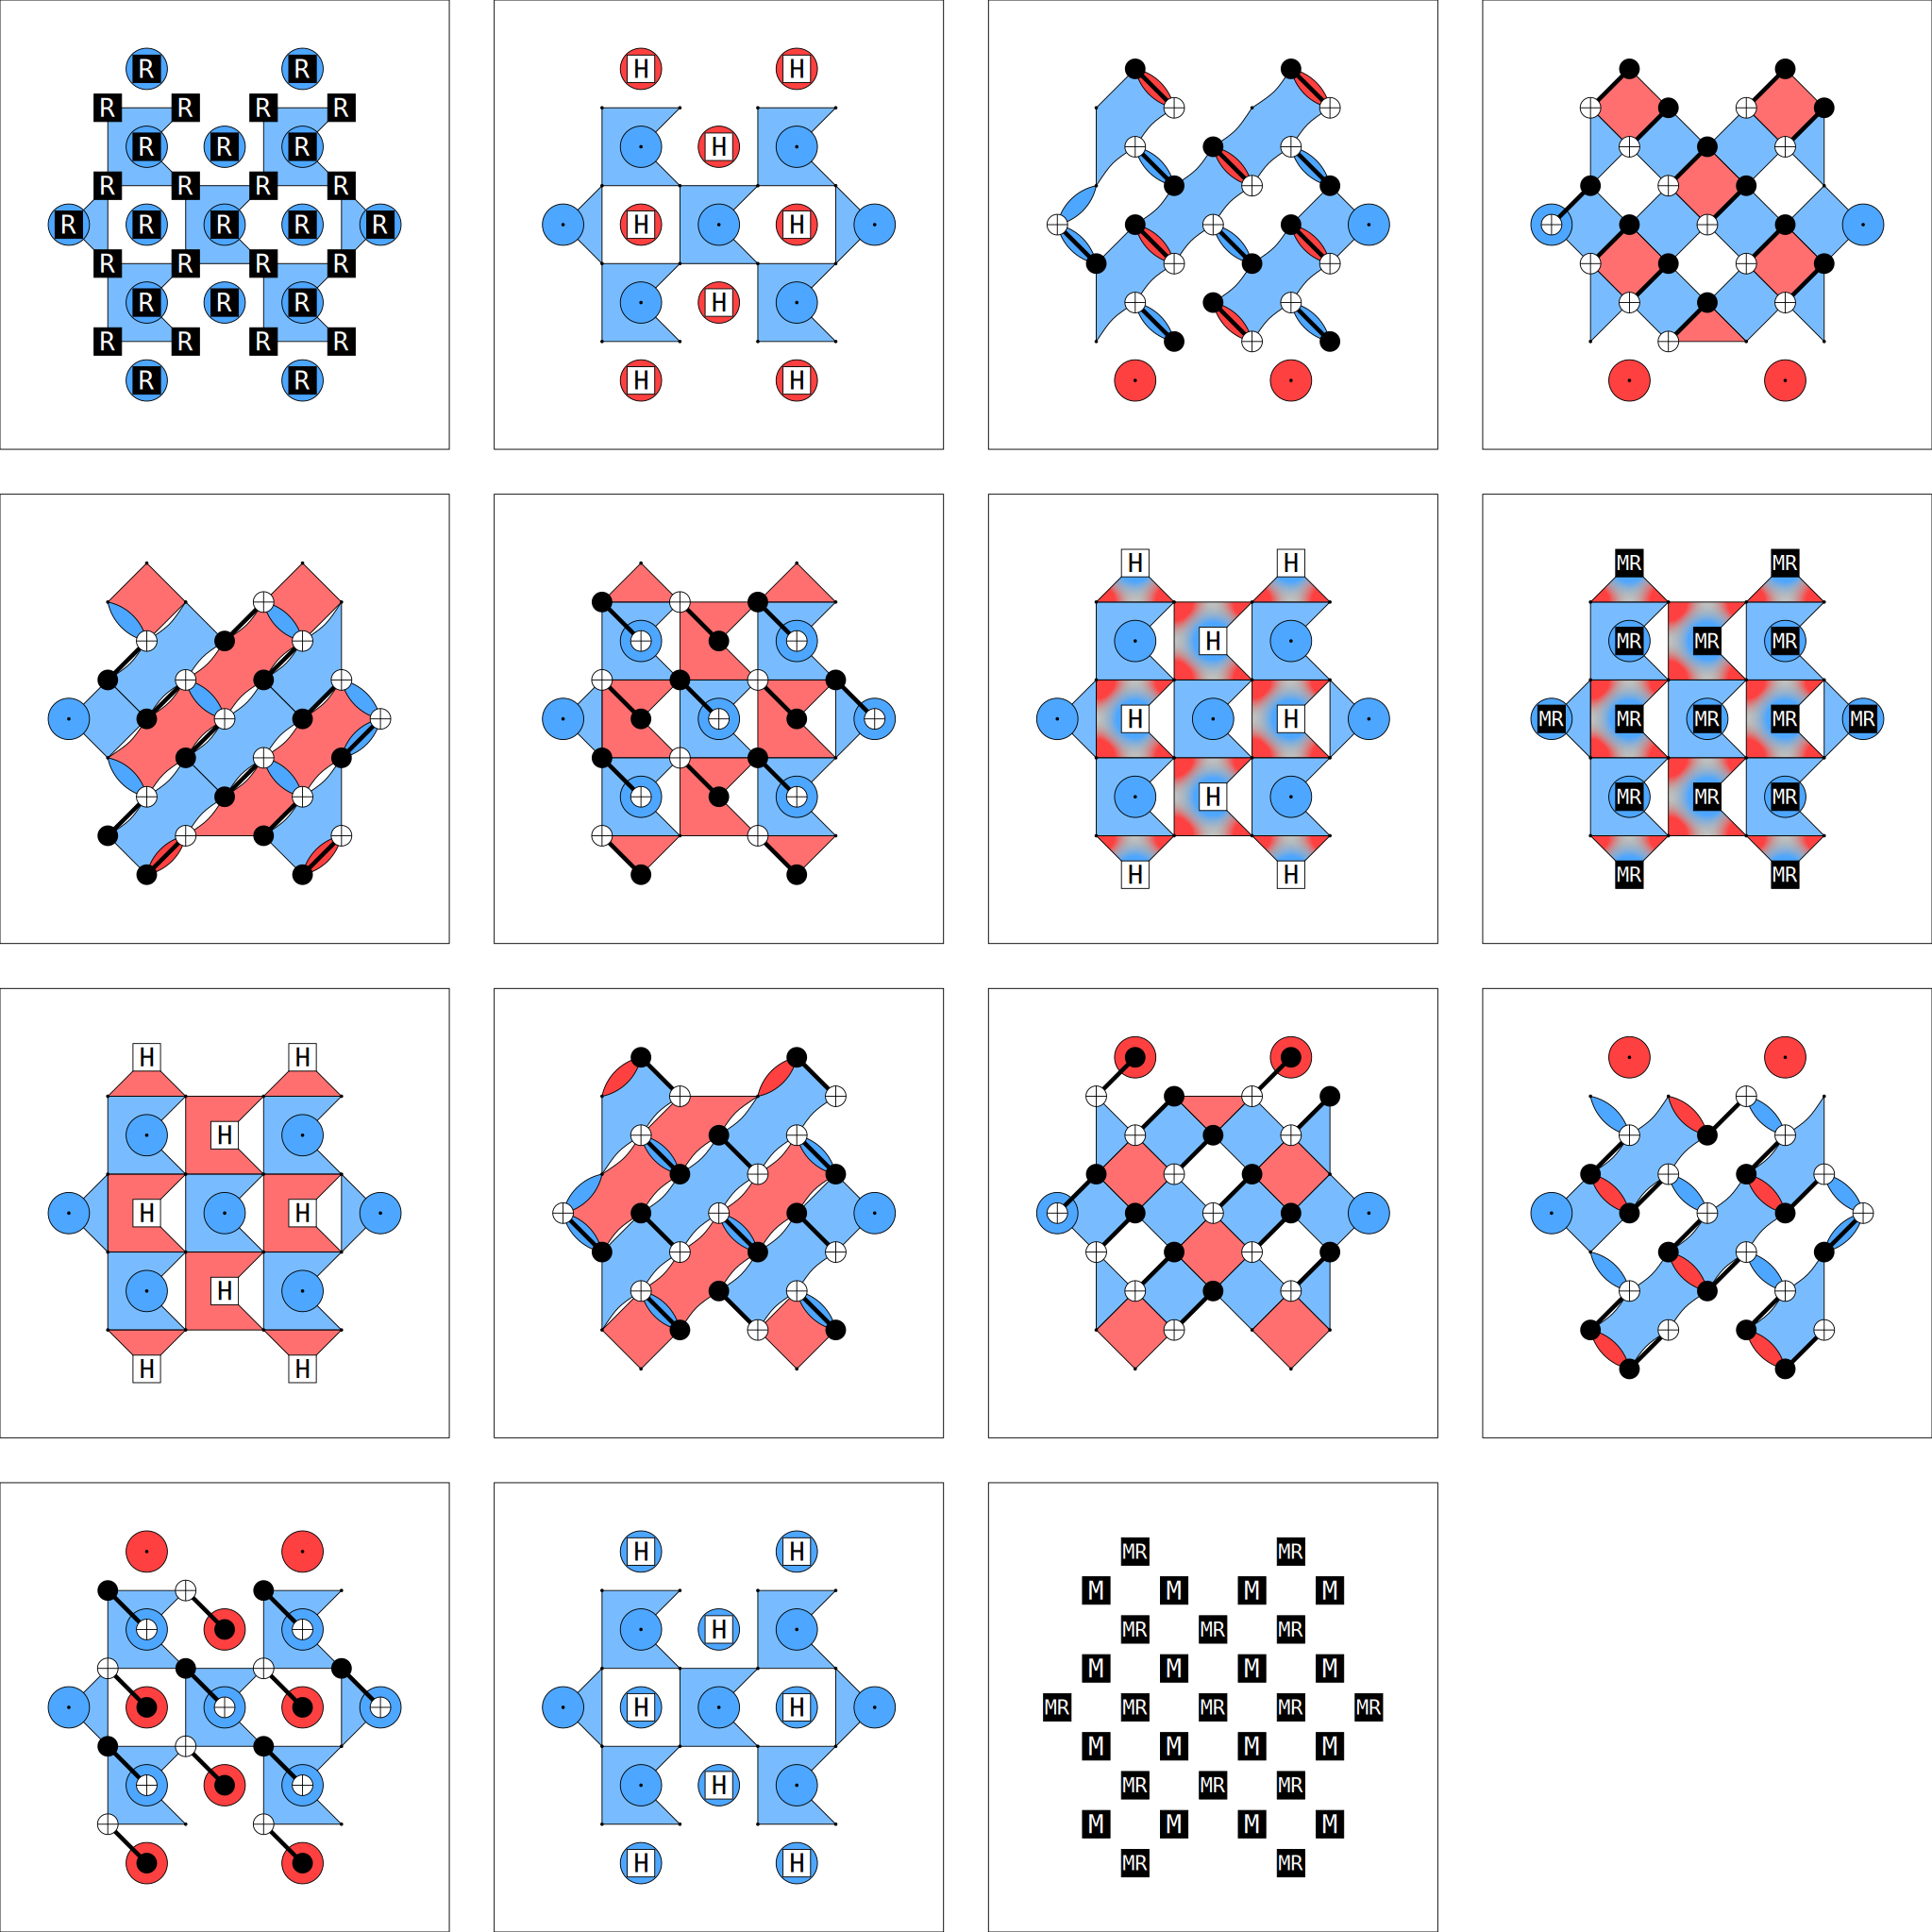

In [2]:
n_samples = 10000000
decoders = ['pymatching']
test_circuit = get_builtin_circuit(
  "surface_code:rotated_memory_"+('z' if use_rotated_z else 'x'),
  distance=d,
  rounds=r,
  before_round_data_depolarization = p,
  after_reset_flip_probability = p,
  after_clifford_depolarization = p,
  before_measure_flip_probability = p
)
m_sampler = test_circuit.compile_sampler(seed=12345)
d_sampler = test_circuit.compile_detector_sampler(seed=12345)
converter = test_circuit.compile_m2d_converter()

measurements = m_sampler.sample(n_samples, bit_packed=False)
det_evts, flips = converter.convert(measurements=measurements, separate_observables=True, bit_packed=False)
measurements = measurements.astype(binary_t)
det_evts = det_evts.astype(binary_t)
flips = flips.astype(binary_t)

avg_flips = np.sum(flips.reshape(-1,), dtype=np.float32)/flips.shape[0]
print(f"Average flip rate: {avg_flips}")

print(test_circuit)
test_circuit.without_noise().diagram('detslice-with-ops-svg')

In [3]:
n_measurements = idx_t(measurements.shape[1])
exclude_indices = np.array([-x-1 for x in range(d**2)], dtype=idx_t)
exclude_indices = exclude_indices + n_measurements
exclude_indices_obsL = np.array([-x-1 for x in range(d*(d-1), d**2)], dtype=idx_t)
exclude_indices_obsL = exclude_indices_obsL + n_measurements
exclude_indices_obs = np.arange(0, n_measurements, 1, dtype=idx_t)
exclude_indices_obs = np.delete(exclude_indices_obs, exclude_indices_obsL)

det_bits = measurements
det_bits = np.delete(det_bits, exclude_indices, axis=1)
obs_bits = measurements
obs_bits = np.delete(obs_bits, exclude_indices_obs, axis=1)
print(obs_bits)

[[1 0 1 0]
 [0 0 1 1]
 [0 1 0 1]
 ...
 [1 1 1 1]
 [0 1 0 1]
 [0 0 1 1]]


In [4]:
detector_error_model = test_circuit.detector_error_model(decompose_errors=True)
pymatcher = pymatching.Matching.from_detector_error_model(detector_error_model)
predictions_pym = pymatcher.decode_batch(det_evts, bit_packed_predictions=False, bit_packed_shots=False)
predictions_pym = predictions_pym.astype(packed_t)

incorrect_matches = (predictions_pym != flips)
incorrect_pym_rate = np.sum(incorrect_matches.reshape(-1,), dtype=np.float32)/incorrect_matches.shape[0]
print(f"PyMatching error rate: {incorrect_pym_rate}")

PyMatching error rate: 0.0436126


In [5]:
# Prepare the input for training
class_bits = obs_bits
class_bits_wpym = np.concatenate((obs_bits, incorrect_matches), axis=1)
print(class_bits)

feature_bits = np.concatenate((det_bits, det_evts), axis=1)
feature_bits_wpym = np.concatenate((det_bits, det_evts, predictions_pym), axis=1)
print(feature_bits[0])

def bit_pack_bits(ev_bits):
  res: packed_t = 0
  for i in range(ev_bits.shape[0]):
    res = res | (packed_t(ev_bits[i]) << i)
  return res

class_bits_packed = np.zeros(class_bits.shape[0], dtype=packed_t)
class_bits_wpym_packed = np.zeros(class_bits_wpym.shape[0], dtype=packed_t)
for iev in range(class_bits.shape[0]):
  class_bits_packed[iev] = bit_pack_bits(class_bits[iev])
  class_bits_wpym_packed[iev] = bit_pack_bits(class_bits_wpym[iev])

[[1 0 1 0]
 [0 0 1 1]
 [0 1 0 1]
 ...
 [1 1 1 1]
 [0 1 0 1]
 [0 0 1 1]]
[1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0]


In [6]:
from utilities_tf import *
test_fraction = 5./10.
feature_bits_train, feature_bits_test, class_bits_train, class_bits_test, feature_bits_train_wpym, feature_bits_test_wpym, class_bits_train_wpym, class_bits_test_wpym = split_data(feature_bits, class_bits_packed, feature_bits_wpym, class_bits_wpym_packed, test_size=test_fraction)

2024-05-27 14:22:37.135194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 14:22:37.286826: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-27 14:22:37.286856: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-27 14:22:37.913762: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [7]:
import tensorflow as tf

print(tf.__version__)
tf.config.list_physical_devices()

2.11.1


2024-05-27 14:22:39.545007: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-05-27 14:22:39.545040: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-05-27 14:22:39.545065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (janish-XPS-8910): /proc/driver/nvidia/version does not exist


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Build models with 2 dense layers with an equal number `nn` of nodes:
- `nn` ranges from 40 to 120 in steps of 10
- One set of models (`models_wpym`) use only the bits for (syndrome measurements) (x) (detection events) (same inherent information but apparently helps with training: https://arxiv.org/abs/2310.05900) as features. The labels are the (bitmap of d(=4) measurements) for which we are eventually looking for an even or odd XOR result.
- In the other set (`models_wpym`), we use bit the bits for (syndrome measurements) (x) (detection events) (x) (one extra bit for the flag from pyMatching that predicts a flip in the XOR result). The labels are the (bitmap of d(=4) measurements) (x) (one bit to flag an incorrect pyMatching prediction).

In this way, any measurement of observable significance ends up being a label for the NN to predict. Any measurement that directly or indirectly relates to the set of syndrome measurements ends up in input features.

Things we could also do is to adjust the layer 1 : layer 2 ratio of the number of nodes, or change the number of layers altogether.

In [8]:
# nnodes = [ nn for nn in range(100, 300, 50)]
nnodes = [100, 250]
nlayers = 2
models_nnonly = []
models_wpym = []
for nn in nnodes:
  node_arg = [ (nn, 8) for _ in range(nlayers) ]

  models_nnonly.append(
    build_sequential_qdense_model(
      feature_bits.shape[1], pow(2, class_bits.shape[1]),
      node_arg,
      loss_fcn = "sparse_categorical_crossentropy",
      output_activation = "softmax"
    )
  )
  models_wpym.append(
    build_sequential_qdense_model(
      feature_bits_wpym.shape[1], pow(2, class_bits_wpym.shape[1]),
      node_arg,
      loss_fcn = "sparse_categorical_crossentropy",
      output_activation = "softmax"
    )
  )

2024-05-27 14:22:39.578478: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_dense (QDense)            (None, 100)               6000      
                                                                 
 q_dense_1 (QDense)          (None, 100)               10100     
                                                                 
 q_dense_2 (QDense)          (None, 16)                1616      
                                                                 
Total params: 17,716
Trainable params: 17,716
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_dense_3 (QDense)          (None, 100)               6100      
                                                                 
 q_dense_4 (QDense)          (

Train the models with no pyMatching input:

In [10]:
i=0
val_split = 0.2
n_epochs = 5 #25
batch_size = 10**3 # 10**4
for model in models_nnonly:
  print(f"Training the model with n_dense = ({nnodes[i]}, {nnodes[i]}) layers:")
  history = model.fit(feature_bits_train, class_bits_train, epochs=n_epochs, batch_size=batch_size, validation_split=val_split)
  # In this test case, looking at the values of accuracies is not informative,
  # but comparing their values between training and testing data sets still tells us about overtraining.
  test_model(model, feature_bits_train, class_bits_train, feature_bits_test, class_bits_test)
  i=i+1
i=0

Training the model with n_dense = (100, 100) layers:
Epoch 1/5
4000/4000 [==============================] - 27s 7ms/step - loss: 2.1805 - accuracy: 0.1202 - val_loss: 2.1813 - val_accuracy: 0.1199
Epoch 2/5
4000/4000 [==============================] - 26s 7ms/step - loss: 2.1800 - accuracy: 0.1204 - val_loss: 2.1803 - val_accuracy: 0.1196
Epoch 3/5
4000/4000 [==============================] - 27s 7ms/step - loss: 2.1794 - accuracy: 0.1202 - val_loss: 2.1808 - val_accuracy: 0.1196
Epoch 4/5
4000/4000 [==============================] - 27s 7ms/step - loss: 2.1790 - accuracy: 0.1203 - val_loss: 2.1814 - val_accuracy: 0.1189
Epoch 5/5
4000/4000 [==============================] - 27s 7ms/step - loss: 2.1788 - accuracy: 0.1201 - val_loss: 2.1801 - val_accuracy: 0.1194
Training data loss: 2.178018, accuracy: 0.120200
Test data loss: 2.179897, accuracy: 0.119662
Training the model with n_dense = (250, 250) layers:
Epoch 1/5
4000/4000 [==============================] - 49s 12ms/step - loss: 2.1

Define a function to translate the bits back to the XOR result:

In [15]:
def get_XOR_prediction(bitmap):
  """
  Assumes that the first four bits correspond to the observable bits that construct the XOR.
  """
  bitsum=0
  for i in range(d):
    bitsum = bitsum + ((bitmap>>i)&1)
  return bitsum%2

Produce the predictions for `models_nnonly`:

In [16]:
# Keep track of the number of wrong bitmap predictions
n_wrong_class_nnonly_train = np.zeros(len(models_nnonly), dtype=np.int32)
n_wrong_class_nnonly_test = np.zeros(len(models_nnonly), dtype=np.int32)
# Keep track of the number of actual XOR flip predictions
n_wrong_XOR_nnonly_train = np.zeros(len(models_nnonly), dtype=np.int32)
n_wrong_XOR_nnonly_test = np.zeros(len(models_nnonly), dtype=np.int32)

imodel = 0
for model in models_nnonly:
  tmp = model.predict(feature_bits_train, batch_size=10000)
  for i in range(tmp.shape[0]):
    jp = 0
    vjp = 0.
    for j in range(tmp.shape[1]):
      if tmp[i][j]>vjp:
        vjp = tmp[i][j]
        jp = j
    if class_bits_train[i] != jp:
      n_wrong_class_nnonly_train[imodel] = n_wrong_class_nnonly_train[imodel] + 1
    has_flip_truth = get_XOR_prediction(class_bits_train[i])
    has_flip_pred = get_XOR_prediction(jp)
    if has_flip_pred != has_flip_truth:
      n_wrong_XOR_nnonly_train[imodel] = n_wrong_XOR_nnonly_train[imodel] + 1
    
  tmp = model.predict(feature_bits_test, batch_size=10000)
  for i in range(tmp.shape[0]):
    jp = 0
    vjp = 0.
    for j in range(tmp.shape[1]):
      if tmp[i][j]>vjp:
        vjp = tmp[i][j]
        jp = j
    if class_bits_test[i] != jp:
      n_wrong_class_nnonly_test[imodel] = n_wrong_class_nnonly_test[imodel] + 1
    has_flip_truth = get_XOR_prediction(class_bits_test[i])
    has_flip_pred = get_XOR_prediction(jp)
    if has_flip_pred != has_flip_truth:
      n_wrong_XOR_nnonly_test[imodel] = n_wrong_XOR_nnonly_test[imodel] + 1

  print(f"Number of wrong training bitmap predictions: {n_wrong_class_nnonly_train[imodel]} / {feature_bits_train.shape[0]}")
  print(f"Number of wrong test bitmap predictions: {n_wrong_class_nnonly_test[imodel]} / {feature_bits_test.shape[0]}")
  print(f"Number of wrong training XOR predictions: {n_wrong_XOR_nnonly_train[imodel]} / {feature_bits_train.shape[0]}")
  print(f"Number of wrong test XOR predictions: {n_wrong_XOR_nnonly_test[imodel]} / {feature_bits_test.shape[0]}")
  imodel = imodel + 1

500/500 [==============================] - 13s 27ms/step
Number of wrong training bitmap predictions: 4398999 / 5000000
Number of wrong test bitmap predictions: 4401691 / 5000000
Number of wrong training XOR predictions: 200674 / 5000000
Number of wrong test XOR predictions: 204526 / 5000000
500/500 [==============================] - 35s 70ms/step
Number of wrong training bitmap predictions: 4394434 / 5000000
Number of wrong test bitmap predictions: 4400804 / 5000000
Number of wrong training XOR predictions: 193868 / 5000000
Number of wrong test XOR predictions: 202760 / 5000000


Train the models with PyMatching input:

In [17]:
i=0
val_split = 0.2
n_epochs = 5 # 25
batch_size = 10**3 # 10**4
for model in models_wpym:
  print(f"Training the model with n_dense = ({nnodes[i]}, {nnodes[i]}) layers:")
  history = model.fit(feature_bits_train_wpym, class_bits_train_wpym, epochs=n_epochs, batch_size=batch_size, validation_split=val_split)
  test_model(model, feature_bits_train_wpym, class_bits_train_wpym, feature_bits_test_wpym, class_bits_test_wpym)
  i=i+1
i=0

Training the model with n_dense = (100, 100) layers:
Epoch 1/5
4000/4000 [==============================] - 31s 8ms/step - loss: 2.2279 - accuracy: 0.1191 - val_loss: 2.1966 - val_accuracy: 0.1194
Epoch 2/5
4000/4000 [==============================] - 30s 7ms/step - loss: 2.1920 - accuracy: 0.1200 - val_loss: 2.1887 - val_accuracy: 0.1193
Epoch 3/5
4000/4000 [==============================] - 30s 7ms/step - loss: 2.1868 - accuracy: 0.1200 - val_loss: 2.1858 - val_accuracy: 0.1196
Epoch 4/5
4000/4000 [==============================] - 30s 7ms/step - loss: 2.1845 - accuracy: 0.1198 - val_loss: 2.1847 - val_accuracy: 0.1197
Epoch 5/5
4000/4000 [==============================] - 27s 7ms/step - loss: 2.1831 - accuracy: 0.1202 - val_loss: 2.1829 - val_accuracy: 0.1200
Training data loss: 2.181566, accuracy: 0.120594
Test data loss: 2.182840, accuracy: 0.119982
Training the model with n_dense = (250, 250) layers:
Epoch 1/5
4000/4000 [==============================] - 55s 13ms/step - loss: 2.2

Produce the predictions with PyMatching input:

In [18]:
# Keep track of the number of wrong bitmap predictions
n_wrong_class_wpym_train = np.zeros(len(models_wpym), dtype=np.int32)
n_wrong_class_wpym_test = np.zeros(len(models_wpym), dtype=np.int32)
# Keep track of the number of actual XOR flip predictions
n_wrong_XOR_wpym_train = np.zeros(len(models_wpym), dtype=np.int32)
n_wrong_XOR_wpym_test = np.zeros(len(models_wpym), dtype=np.int32)

imodel = 0
for model in models_wpym:
  tmp = model.predict(feature_bits_train_wpym, batch_size=10000)
  for i in range(tmp.shape[0]):
    jp = 0
    vjp = 0.
    for j in range(tmp.shape[1]):
      if tmp[i][j]>vjp:
        vjp = tmp[i][j]
        jp = j
    if class_bits_train_wpym[i] != jp:
      n_wrong_class_wpym_train[imodel] = n_wrong_class_wpym_train[imodel] + 1
    has_flip_truth = get_XOR_prediction(class_bits_train_wpym[i])
    has_flip_pred = get_XOR_prediction(jp)
    if has_flip_pred != has_flip_truth:
      n_wrong_XOR_wpym_train[imodel] = n_wrong_XOR_wpym_train[imodel] + 1
    
  tmp = model.predict(feature_bits_test_wpym, batch_size=10000)
  for i in range(tmp.shape[0]):
    jp = 0
    vjp = 0.
    for j in range(tmp.shape[1]):
      if tmp[i][j]>vjp:
        vjp = tmp[i][j]
        jp = j
    if class_bits_test_wpym[i] != jp:
      n_wrong_class_wpym_test[imodel] = n_wrong_class_wpym_test[imodel] + 1
    has_flip_truth = get_XOR_prediction(class_bits_test_wpym[i])
    has_flip_pred = get_XOR_prediction(jp)
    if has_flip_pred != has_flip_truth:
      n_wrong_XOR_wpym_test[imodel] = n_wrong_XOR_wpym_test[imodel] + 1

  print(f"Number of wrong training bitmap predictions: {n_wrong_class_wpym_train[imodel]} / {feature_bits_train_wpym.shape[0]}")
  print(f"Number of wrong test bitmap predictions: {n_wrong_class_wpym_test[imodel]} / {feature_bits_test_wpym.shape[0]}")
  print(f"Number of wrong training XOR predictions: {n_wrong_XOR_wpym_train[imodel]} / {feature_bits_train_wpym.shape[0]}")
  print(f"Number of wrong test XOR predictions: {n_wrong_XOR_wpym_test[imodel]} / {feature_bits_test_wpym.shape[0]}")
  imodel = imodel + 1

500/500 [==============================] - 12s 23ms/step
Number of wrong training bitmap predictions: 4397028 / 5000000
Number of wrong test bitmap predictions: 4400089 / 5000000
Number of wrong training XOR predictions: 205176 / 5000000
Number of wrong test XOR predictions: 206475 / 5000000
500/500 [==============================] - 32s 64ms/step
Number of wrong training bitmap predictions: 4396134 / 5000000
Number of wrong test bitmap predictions: 4400290 / 5000000
Number of wrong training XOR predictions: 201460 / 5000000
Number of wrong test XOR predictions: 203876 / 5000000


Define a function to get quantiles and uncertainties in efficiency:

In [19]:
from scipy.stats import chi2 as chisq
from scipy.stats import binomtest

chisquared_cdf = chisq.cdf
chisquared_quantile = chisq.ppf

def get_CL_for_ndof(m2dll, ndof):
  return chisquared_cdf(m2dll, df=ndof)

VAL_CL_1SIGMA = get_CL_for_ndof(1., 1)
VAL_CL_2SIGMA = get_CL_for_ndof(4., 1)

def counting_interval(sw_total, swsq_total=None, CL = VAL_CL_1SIGMA):
  quant = (1.-CL)/2.
  count = 0.
  if swsq_total is None or swsq_total<=0.:
    count = sw_total
  else:
    count = sw_total**2/swsq_total
  vlow = (chisquared_quantile(quant, 2.*count) / 2. if count!=0. else 0.)
  vhigh = chisquared_quantile(1.-quant, 2.*(count+1.)) / 2.
  if count>0.:
    vlow = vlow * sw_total / count
    vhigh = vhigh * sw_total / count
  return (vlow, vhigh)

def efficiency_interval(sw_passed, sw_total, swsq_total=None, CL = VAL_CL_1SIGMA):
  normval = 1.
  if swsq_total is not None and swsq_total>0.:
    normval = sw_total/swsq_total
  passed = np.int32(sw_passed*normval)
  total = np.int32(sw_total*normval)
  ci = binomtest(k=passed, n=total).proportion_ci(method='exact', confidence_level=CL)
  return (ci.low, ci.high)

Make a plot to compare the prediction inaccuracy:

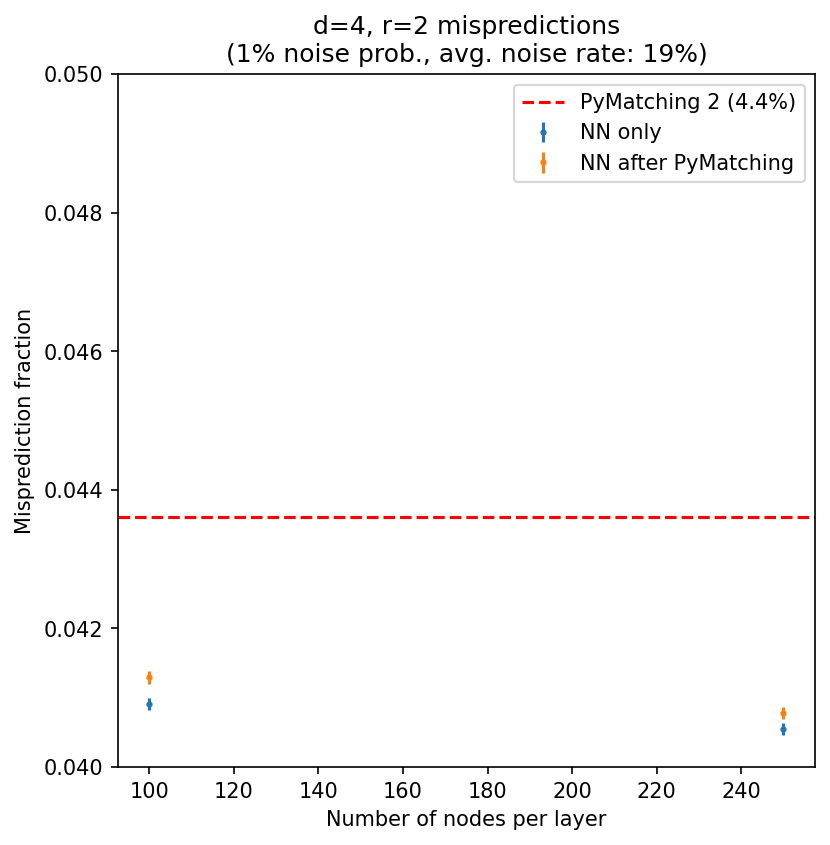

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True)

eff_wrong_XOR_nnonly_test = np.zeros(shape=(n_wrong_XOR_nnonly_test.shape[0],3), dtype=np.float32)
eff_wrong_XOR_wpym_test = np.zeros(shape=(n_wrong_XOR_wpym_test.shape[0],3), dtype=np.float32)
for iev in range(n_wrong_XOR_nnonly_test.shape[0]):
  eff_wrong_XOR_nnonly_test[iev][0] = np.float32(n_wrong_XOR_nnonly_test[iev]/feature_bits_test.shape[0])
  eff_wrong_XOR_wpym_test[iev][0] = np.float32(n_wrong_XOR_wpym_test[iev]/feature_bits_test_wpym.shape[0])
  eff_wrong_XOR_nnonly_test[iev][1], eff_wrong_XOR_nnonly_test[iev][2] = np.float32(efficiency_interval(n_wrong_XOR_nnonly_test[iev], feature_bits_test.shape[0]))
  eff_wrong_XOR_wpym_test[iev][1], eff_wrong_XOR_wpym_test[iev][2] = np.float32(efficiency_interval(n_wrong_XOR_wpym_test[iev], feature_bits_test_wpym.shape[0]))

ax.errorbar(
  x=nnodes,
  y=eff_wrong_XOR_nnonly_test[:,0],
  yerr=[
    eff_wrong_XOR_nnonly_test[:,0]-eff_wrong_XOR_nnonly_test[:,1],
    eff_wrong_XOR_nnonly_test[:,2]-eff_wrong_XOR_nnonly_test[:,0]
  ],
  fmt='o',
  label='NN only',
  markersize=2
)
ax.errorbar(
  x=nnodes,
  y=eff_wrong_XOR_wpym_test[:,0],
  yerr=[
    eff_wrong_XOR_wpym_test[:,0]-eff_wrong_XOR_wpym_test[:,1],
    eff_wrong_XOR_wpym_test[:,2]-eff_wrong_XOR_wpym_test[:,0]
  ],
  fmt='o',
  label='NN after PyMatching',
  markersize=2
)
ax.axhline(y=incorrect_pym_rate, color='r', linestyle='--', label=f'PyMatching 2 ({incorrect_pym_rate*100.:.1f}%)')
ax.set_xlabel('Number of nodes per layer')
ax.set_ylabel('Misprediction fraction')
ax.set_title(f'd={d}, r={r} mispredictions\n({int(p*100)}% noise prob., avg. noise rate: {avg_flips*100.:.0f}%)')
ax.legend()
ax.set_ylim([4e-2, 5e-2])
#ax.set_yscale('log')
fig.set_dpi(150)